### Script to compute paleo runoff maps for ece4 starting from orographic slope

In [2]:
import xarray as xr
from climtools import climtools_lib as ctl
from matplotlib import pyplot as plt
import numpy as np

cart = '/work/users/clima/fabiano/ece4/'

In [3]:
oroslope = xr.load_dataset(cart + 'herold_etal_eocene_runoff_1x1.nc')

In [4]:
oroslope

<xarray.Dataset> Size: 778kB
Dimensions:             (nj: 180, ni: 360)
Dimensions without coordinates: nj, ni
Data variables:
    RTM_FLOW_DIRECTION  (nj, ni) float32 259kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    xc                  (nj, ni) float32 259kB -179.5 -178.5 ... 178.5 179.5
    yc                  (nj, ni) float32 259kB -89.5 -89.5 -89.5 ... 89.5 89.5
Attributes:
    history:  created by nherold 2014

In [5]:
oroslope = oroslope.rename({'xc': 'longitude', 'yc': 'latitude'})
oroslope = oroslope.assign_coords(longitude = oroslope.longitude[0], latitude = oroslope.latitude[:, 0])

In [6]:
oroslope

<xarray.Dataset> Size: 261kB
Dimensions:             (nj: 180, ni: 360)
Coordinates:
    longitude           (ni) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
    latitude            (nj) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Dimensions without coordinates: nj, ni
Data variables:
    RTM_FLOW_DIRECTION  (nj, ni) float32 259kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
Attributes:
    history:  created by nherold 2014

Adding cyclic point



<GeoAxes: >

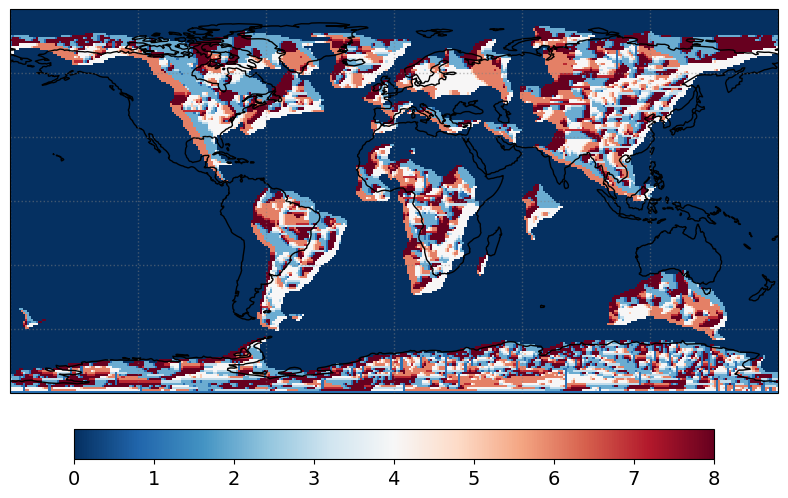

In [7]:
ctl.plot_map_contour(oroslope['RTM_FLOW_DIRECTION'], plot_type = 'pcolormesh')

In [8]:
flowdir = oroslope['RTM_FLOW_DIRECTION'].values

In [9]:
flowdir.shape

(180, 360)

In [10]:
flowdir[179, 0]

np.float32(0.0)

### Functions

In [126]:
def follow_point(i, j, flowdir = flowdir, verbose = False):
    """
    Tracks a point to the next one, following the slope given by flowdir.
    """
    
    compass = 'N NE E SE S SW W NW'.split()

    if verbose: print(flowdir[i,j])

    if flowdir[i,j] == 0:
        if verbose: print('Sea point!')
        return np.nan
    
    dir_ok = compass[int(flowdir[i,j]-1)]
    next = np.array([0, 0])

    if 'N' in dir_ok:
        next += np.array([1, 0])
    if 'S' in dir_ok:
        next += np.array([-1, 0])
    if 'E' in dir_ok:
        next += np.array([0, 1])
    if 'W' in dir_ok:
        next += np.array([0, -1])

    newpo = np.array([i,j]) + next

    newpo_ok = newpo.copy()
    if newpo[0] == 180:
        newpo_ok[0] = 178 # if passing north pole
    if newpo[0] == -1:
        newpo_ok[0] = 1 # if passing south pole
    if newpo[1] == 360:
        newpo_ok[1] = 0 # if passing east boundary
    if newpo[1] == -1:
        newpo_ok[1] = 359 # if passing west boundary
    
    return newpo_ok


def find_sea(i, j, flowdir = flowdir, verbose = False):
    point = np.array([i,j])
    nupo = point.copy()
    val = flowdir[nupo[0], nupo[1]]

    if val == 0:
        if verbose: print('Already a sea point!')
        return 2, np.nan, np.nan, np.nan

    count = 0
    while val > 0:
        if verbose: print(f'step {count}')
        last = nupo.copy()
        nupo = follow_point(nupo[0], nupo[1])
        val = flowdir[nupo[0], nupo[1]]
        count += 1

        if count > 100: break
    
    if count > 100:
        if verbose: print('Ended in a loophole!')
        return 1, np.nan, np.nan, np.nan
    else:
        if verbose: print(f'Found sea at ({nupo[0]}, {nupo[1]})')
        return 0, nupo, last, int(flowdir[last[0], last[1]])
    

def track_rivers(flowdir):
    """
    Finds basins and river exit points from a global slope map.
    """
    rivers = []
    rivers_dir = []
    rnf_map = np.zeros((180, 360))-1

    for j in range(360):
        for i in range(180):
            res, po, pocoast, podir = find_sea(i, j, flowdir = flowdir)

            if res == 0:
                # if len(rivers) == 0:
                #     rivers.append(po)
                #     continue
                # if not np.any(np.array(rivers) == po):
                    # rivers.append(po)
                if tuple(po) not in rivers:
                    rivers.append(tuple(po))
                    rivers_dir.append(podir)
                
                rnf_map[i,j] = rivers.index(tuple(po))
                #rnf_map[i,j] = np.argmin(rivers == po)
                
            elif res == 1:
                rnf_map[i,j] = -1
            elif res == 2:
                rnf_map[i,j] = -2
        
    print(f'Found {len(rivers)} rivers!')
    
    return rnf_map, rivers, rivers_dir


def track_rivers_vct(flowdir):
    """
    With arrays, but slower. Don't use!!
    """
    rivers = []
    rivers_dir = []
    rnf_map = np.zeros((180, 360))-1

    for j in range(360):
        for i in range(180):
            res, po, pocoast, podir = find_sea(i, j)

            if res == 0:
                if len(rivers) == 0:
                    rivers.append(po)
                    continue

                if not np.any(np.all(np.array(rivers) == po, axis = 1)):
                    rivers.append(po)
                    rivers_dir.append(podir)
                
                #rnf_map[i,j] = rivers.index(tuple(po))
                rnf_map[i,j] = np.where(np.all(np.array(rivers) == po, axis = 1))[0][0]
                
            elif res == 1:
                rnf_map[i,j] = -1
            elif res == 2:
                rnf_map[i,j] = -2
    
    return rnf_map, rivers, rivers_dir


def plot_basins(rnf_map, rivers = None, not_assigned = None, shuffle = True):
    fig = plt.figure(figsize = (16,12))
    cmap = plt.get_cmap('nipy_spectral').copy()
    cmap.set_under('grey')  # Color for values < vmin

    if shuffle:
        unique_vals = np.unique(rnf_map)
        unique_vals = unique_vals[unique_vals >= 0]
        random_vals = np.random.choice(len(unique_vals), size=len(unique_vals), replace=False)
        randvals = np.select([rnf_map == v for v in unique_vals], random_vals)
        randvals[rnf_map < 0] = -2
        plt.imshow(randvals[::-1, :], cmap=cmap, vmin = 0)
    else:
        plt.imshow(rnf_map[::-1, :], cmap=cmap, vmin = 0)

    if rivers is not None:
        for randv, riv in zip(random_vals, rivers):
            col = cmap(randv/np.max(random_vals))
            plt.scatter(riv[1], 180-riv[0], color = col, s = 20, marker = 'D', edgecolor = 'black')
    
    if not_assigned is not None:
        for po in not_assigned:
            plt.scatter(po[1], 180-po[0], color = 'white', s = 10, marker = 'o', edgecolor = 'black')
    
    return fig


def calc_basins_dim(rnf_map, lat = oroslope.latitude):
    coslat = np.abs(np.cos(np.deg2rad(lat)))
    coslat2d = np.tile(coslat, (360, 1)).T  # Shape

    basins = []
    for ri in range(int(np.max(rnf_map)+1)):
        #basins.append(np.sum(rnf_map == ri))
        basins.append(np.sum(coslat2d[rnf_map == ri]))
        
    basins = np.array(basins)
    return basins


def get_largest_basins(rnf_map, rivers, rivers_dir, lat = oroslope.latitude, basin_thres = 50):
    basins = calc_basins_dim(rnf_map, lat = oroslope.latitude)

    print(f'Selecting {np.sum(basins > basin_thres)} largest basins!')

    big_basins = list(np.where(basins > basin_thres)[0])

    big_rivers = [rivers[i] for i in big_basins]
    big_rivers_dir = [rivers_dir[i] for i in big_basins]

    return big_rivers, big_rivers_dir, big_basins


def track_rivers_and_merge(big_rivers, big_rivers_dir, flowdir = flowdir, riv_thres = 30, dir_thres = 1, use_expanded = True, weight_for_lat = False, lat = oroslope.latitude):
    """
    Tracks rivers and merges small basins to get a reasonable global number of basins.

    riv_thres = 30 # max distance of river to merge
    dir_thres = 1 # max diff in direction
    use_expanded = True # if this is True, it will look not only at the original river estuary, but also at the connected points (slower, but should produce less river basins and ideally more connected)
    weight_for_lat = False # if this is True, the distance is computed weighting for latitude

    """
    coslat = np.abs(np.cos(np.deg2rad(lat)))
    coslat2d = np.tile(coslat, (360, 1)).T  # Shape

    rivers_v2 = [] + big_rivers
    rivers_v2_dir = [] + big_rivers_dir
    rivers_merged = dict()
    for ii, cos in enumerate(rivers_v2):
        rivers_merged[ii] = [np.array(cos)]
    # coastlines = []

    rnf_map_merged = np.zeros((180, 360))-1
    for j in range(360):
        for i in range(180):
            res, po, pocoast, podir = find_sea(i, j, flowdir = flowdir)

            if res == 0:
                if tuple(po) in big_rivers: 
                    print('This is a big river! keeping as is')
                    if tuple(po) not in rivers_v2:
                        rivers_v2.append(tuple(po))
                        rivers_v2_dir.append(podir)
                
                    rnf_map_merged[i,j] = rivers_v2.index(tuple(po))
                else:
                    print('Small river, checking nearby')
                    if tuple(po) not in rivers_v2:
                        ## now for merged
                        # find a river close-by
                        # if the direction is similar (podir +/- 1), then merge
                        # if the dir is different or no river close-by, add new river
                        # rivers merged is a dict of lists

                        # Adding new points assigned to each basin to obtain connected regions
                        if use_expanded:
                            rivers_expanded = rivers_v2.copy()
                            rivers_dir_expanded = rivers_v2_dir.copy()
                            rivers_idx = np.arange(len(rivers_v2))
                            for ri in rivers_merged:
                                rivers_expanded += rivers_merged[ri][1:]
                                rivers_dir_expanded += (len(rivers_merged[ri])-1)*[rivers_v2_dir[ri]]
                                rivers_idx = np.append(rivers_idx, (len(rivers_merged[ri])-1)*[ri])

                            riv_ok = np.abs(np.array(rivers_dir_expanded) - podir) <= dir_thres
                            ok_inds = rivers_idx[riv_ok]

                            sqdist = np.sum((np.array(rivers_expanded)[riv_ok] - np.array(po))**2, axis = 1)
                        else:
                            riv_ok = np.abs(np.array(rivers_v2_dir) - podir) <= dir_thres
                            rivers_idx = np.arange(len(rivers_v2))
                            ok_inds = rivers_idx[riv_ok]

                            sqdist = np.sum((np.array(rivers_v2)[riv_ok] - np.array(po))**2, axis = 1)

                        closest = int(ok_inds[np.argmin(sqdist)])

                        if weight_for_lat:
                            dist = coslat2d[po[0], po[1]] * np.sqrt(np.min(sqdist))
                        else:
                            dist = np.sqrt(np.min(sqdist))

                        print(dist, closest)
                        if dist < riv_thres:
                            print('Found small river nearby!')
                            rnf_map_merged[i,j] = closest
                            if not np.any(rivers_merged[closest] == po):
                                rivers_merged[closest].append(po)
                        else:
                            print('No small river nearby, adding one')
                            # not found a river close-by, adding new one
                            rivers_v2.append(tuple(po))
                            rivers_v2_dir.append(podir)

                            ind = rivers_v2.index(tuple(po))
                            rivers_merged[ind] = [po]
                            rnf_map_merged[i,j] = ind

                    else:
                        # tuple(po) already in rivers_v2
                        rnf_map_merged[i,j] = rivers_v2.index(tuple(po))

            elif res == 1:
                rnf_map_merged[i,j] = -1
            elif res == 2:
                rnf_map_merged[i,j] = -2
        
        print(f'Found {len(rivers_v2)} rivers with {len(big_rivers)} big rivers!')

    return rnf_map_merged, rivers_merged, rivers_v2, rivers_v2_dir


def drop_assign_fill(rnf_map_merged, rivers_v2, rivers_v2_dir, lat = oroslope.latitude, basin_thres = 50):
    """
    After the merge, some basins are still below threshold. This routine drops the small basins and assigns the points to one of the closest basins (takes a random neighboring point). The routine goes in loops to assign all points.
    """

    big_rivers_2, big_rivers_dir_2, ok_indx = get_largest_basins(rnf_map_merged, rivers_v2, rivers_v2_dir, lat = lat, basin_thres = basin_thres)

    for ind in range(len(rivers_v2)):
        if ind not in list(ok_indx):
            print(f'{ind}: small basin, deassigning..')
            rnf_map_merged[rnf_map_merged == ind] = -1


    rnf_map_filled = rnf_map_merged.copy()
    nla, nlo = rnf_map_merged.shape

    missing = True
    i_count = 0
    while missing and i_count < 20:
        print(f'We are at {i_count} round of assignments')
        i_count += 1
        missing = False
        not_assigned = []
        for i in range(nla):
            for j in range(nlo):
                if rnf_map_filled[i,j] == -1:
                    print('To be assigned')
                    # Search for neighboring points

                    #print(i-1, i+2, j-1, j+2)
                    ini_i = i-1
                    ini_j = j-1
                    if ini_i < 0: ini_i = 0
                    if ini_j < 0: ini_j = 0
                    neighbors = rnf_map_filled[ini_i:i+2, ini_j:j+2].flatten()
                    print(neighbors)

                    if np.any(neighbors >= 0):
                        # assign closest non-zero
                        new_ind = neighbors[np.where(neighbors >= 0)[0][0]]
                        print(f'Assigning to {new_ind}')
                        rnf_map_filled[i, j] = int(new_ind)
                    else:
                        missing = True
                        not_assigned.append((i,j))

    return rnf_map_merged, not_assigned


def iter_track(flowdir = flowdir, basin_thres = 50, riv_thres = 30, dir_thres = 1, lat = oroslope.latitude, n_iter = 5):
    rnf_map, rivers, rivers_dir = track_rivers(flowdir)

    big_rivers, big_rivers_dir, big_basins = get_largest_basins(rnf_map, rivers, rivers_dir, lat = lat, basin_thres = basin_thres)

    rnf_map_merged, rivers_merged, rivers, rivers_dir = track_rivers_and_merge(big_rivers, big_rivers_dir, flowdir = flowdir, riv_thres = riv_thres, dir_thres = dir_thres, use_expanded = True, weight_for_lat = False)

    ### Now, loop: keep only largest, assign remaining according to a fixed rivers_merged (not updating and not adding new rivers)
    rnf_map_merged_final, not_assigned = drop_assign_fill(rnf_map_merged, rivers, rivers_dir, lat = lat, basin_thres = basin_thres)

    return rnf_map_merged_final, rivers_merged, rivers, not_assigned


def out_runoffmap_nc(rnf_map_merged_final, rivers_merged, rivers_end_point):
    # Load old runoffmap
    rnf_pd = xr.load_dataset(cart + 'runoff_maps.nc')

    rnf_new = rnf_pd.copy()

    pass


In [134]:
import xesmf as xe

def create_basin_data(output_file, ds_target, drainage_basin_id, arrival_point_id, calving_point_id, lon_source, lat_source, method='nearest_s2d'):
    """
    Creates drainage_basin_id, arrival_point_id, and calving_point_id arrays
    based on an existing target dataset and saves to a NetCDF file.
    
    Parameters:
    -----------
    ds_target : xarray.Dataset
        Target dataset with desired grid dimensions (512x256)
    output_file : str
        Path to save the output NetCDF file
    method : str, optional
        Regridding method (default 'nearest_s2d')
    
    Returns:
    --------
    xarray.Dataset
        Dataset containing the three data variables at target resolution
    """
    
    # Create source dataset
    ds_source = xr.Dataset(
        data_vars={
            'drainage_basin_id': (['lat', 'lon'], drainage_basin_id),
            'arrival_point_id': (['lat', 'lon'], arrival_point_id),
            'calving_point_id': (['lat', 'lon'], calving_point_id)
        },
        coords={
            'lon': lon_source,
            'lat': lat_source
        }
    )
    
    # Create regridder
    regridder = xe.Regridder(ds_source, ds_target, method)
    
    # Apply regridding and create target dataset
    result = xr.Dataset(
        data_vars={
            'drainage_basin_id': (['lat', 'lon'], regridder(ds_source.drainage_basin_id).data.astype(np.int32)),
            'arrival_point_id': (['lat', 'lon'], regridder(ds_source.arrival_point_id).data.astype(np.int32)),
            'calving_point_id': (['lat', 'lon'], regridder(ds_source.calving_point_id).data.astype(np.int32))
        },
        coords=ds_target.coords
    )
    
    # Save to NetCDF
    result.to_netcdf(output_file)
    
    return result


In [106]:
rnf_pd.

AttributeError: 'Dataset' object has no attribute 'vars'

In [104]:
[var.long_name for var in rnf_pd.variables]

AttributeError: 'str' object has no attribute 'long_name'

### The calc

In [127]:
rnf_map_merged_final, rivers_merged_final, rivers_end_point, not_assigned = iter_track(flowdir)
print(not_assigned)

Found 2741 rivers!
Selecting 39 largest basins!
Small river, checking nearby
133.96268137059664 5
No small river nearby, adding one
Small river, checking nearby
Small river, checking nearby
Small river, checking nearby
1.0 39
Found small river nearby!
Small river, checking nearby
1.0 39
Found small river nearby!
Small river, checking nearby
1.0 39
Found small river nearby!
Small river, checking nearby
1.0 39
Found small river nearby!
Small river, checking nearby
162.01234520862909 9
No small river nearby, adding one
Small river, checking nearby
Small river, checking nearby
107.56393447619885 3
No small river nearby, adding one
Small river, checking nearby
1.0 41
Found small river nearby!
Small river, checking nearby
1.4142135623730951 41
Found small river nearby!
Small river, checking nearby
1.0 41
Found small river nearby!
Small river, checking nearby
112.44998888394787 2
No small river nearby, adding one
Small river, checking nearby
Small river, checking nearby
Small river, checking 

In [140]:
create_basin_data('runoff_map_new.nc', rnf_pd, rnf_map_merged_final, arrival_id, np.zeros(arrival_id.shape)-2, oroslope.longitude, oroslope.latitude)

/work/users/clima/fabiano/miniforge3/envs/climtools/lib/python3.12/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable drainage_basin_id as the horizontal dimensions for the regridding.
  warnings.warn(
/work/users/clima/fabiano/miniforge3/envs/climtools/lib/python3.12/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable arrival_point_id as the horizontal dimensions for the regridding.
  warnings.warn(
/work/users/clima/fabiano/miniforge3/envs/climtools/lib/python3.12/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable calving_point_id as the horizontal dimensions for the regridding.
  warnings.warn(


<xarray.Dataset> Size: 2MB
Dimensions:            (lat: 256, lon: 512)
Coordinates:
  * lon                (lon) float64 4kB 0.0 0.7031 1.406 ... 357.9 358.6 359.3
  * lat                (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.77 89.46
Data variables:
    drainage_basin_id  (lat, lon) int32 524kB 14 14 14 14 14 ... -2 -2 -2 -2 -2
    arrival_point_id   (lat, lon) int32 524kB -2 -2 -2 -2 -2 ... -2 -2 -2 -2 -2
    calving_point_id   (lat, lon) int32 524kB -2 -2 -2 -2 -2 ... -2 -2 -2 -2 -2

In [136]:
rnf_map_new = xr.load_dataset('runoff_map_new.nc')

In [ ]:
rnf_map_new

<xarray.Dataset> Size: 2MB
Dimensions:            (lat: 256, lon: 512)
Coordinates:
  * lon                (lon) float64 4kB 0.0 0.7031 1.406 ... 357.9 358.6 359.3
  * lat                (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.77 89.46
Data variables:
    drainage_basin_id  (lat, lon) int32 524kB 14 14 14 14 14 ... -2 -2 -2 -2 -2
    arrival_point_id   (lat, lon) int32 524kB -2 -2 -2 -2 -2 ... -2 -2 -2 -2 -2
    calving_point_id   (lat, lon) int32 524kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

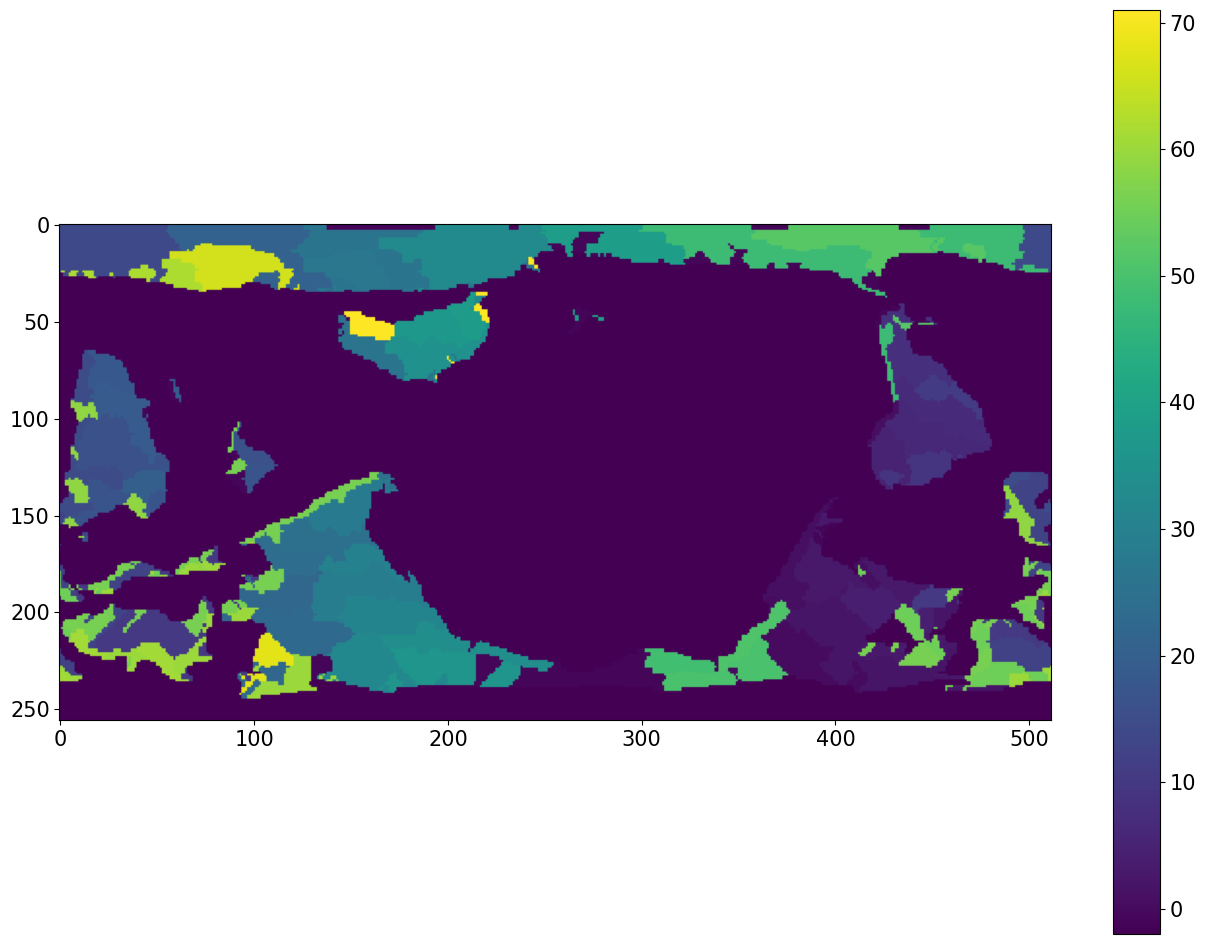

In [138]:
plt.figure(figsize=(16,12))
plt.imshow(rnf_map_new.drainage_basin_id)
plt.colorbar()

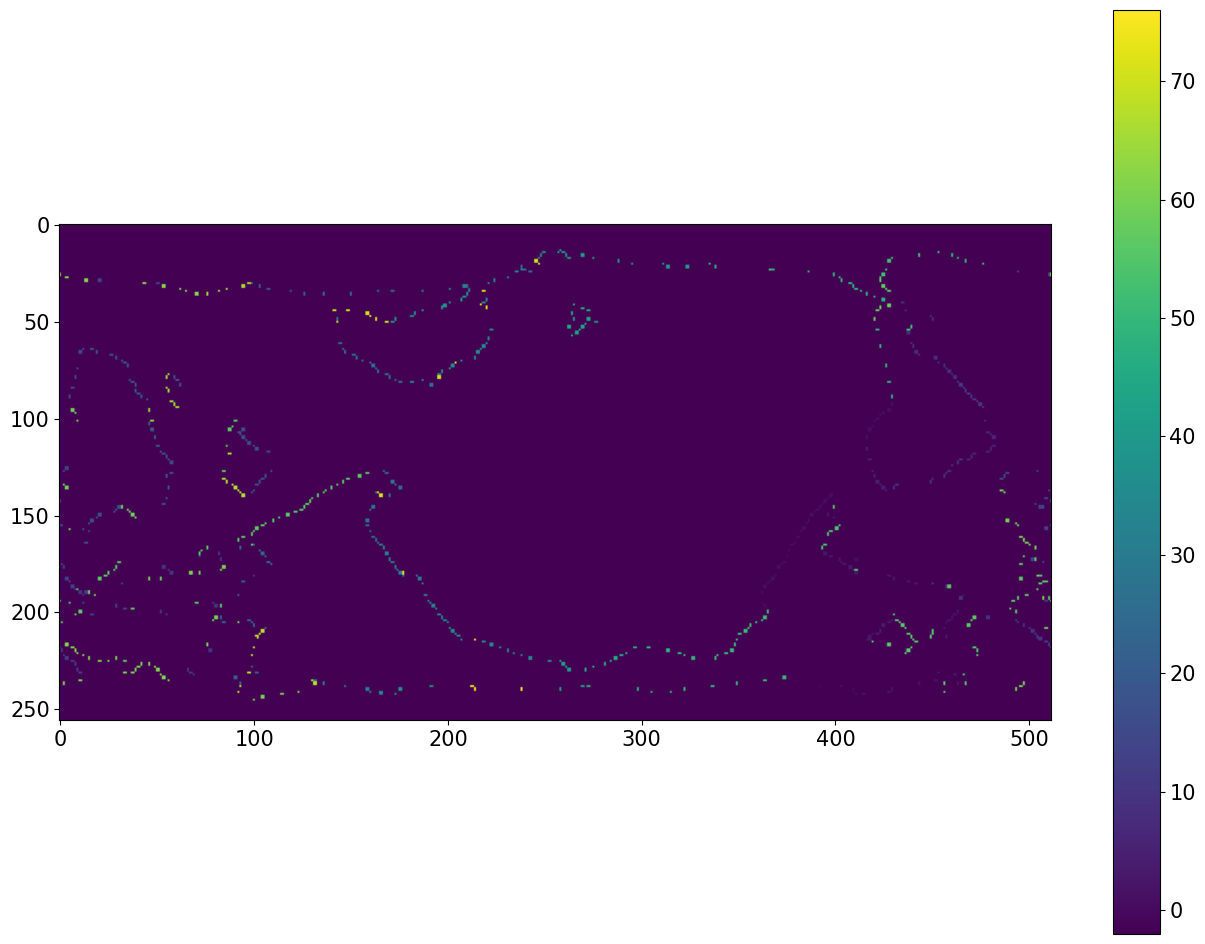

In [139]:
plt.figure(figsize=(16,12))
plt.imshow(rnf_map_new.arrival_point_id)
plt.colorbar()

In [ ]:
arrival_id = np.zeros(rnf_map_merged_final.shape) - 2
for num in rivers_merged_final:
    for po in rivers_merged_final[num]:
        arrival_id[po[0], po[1]] = num

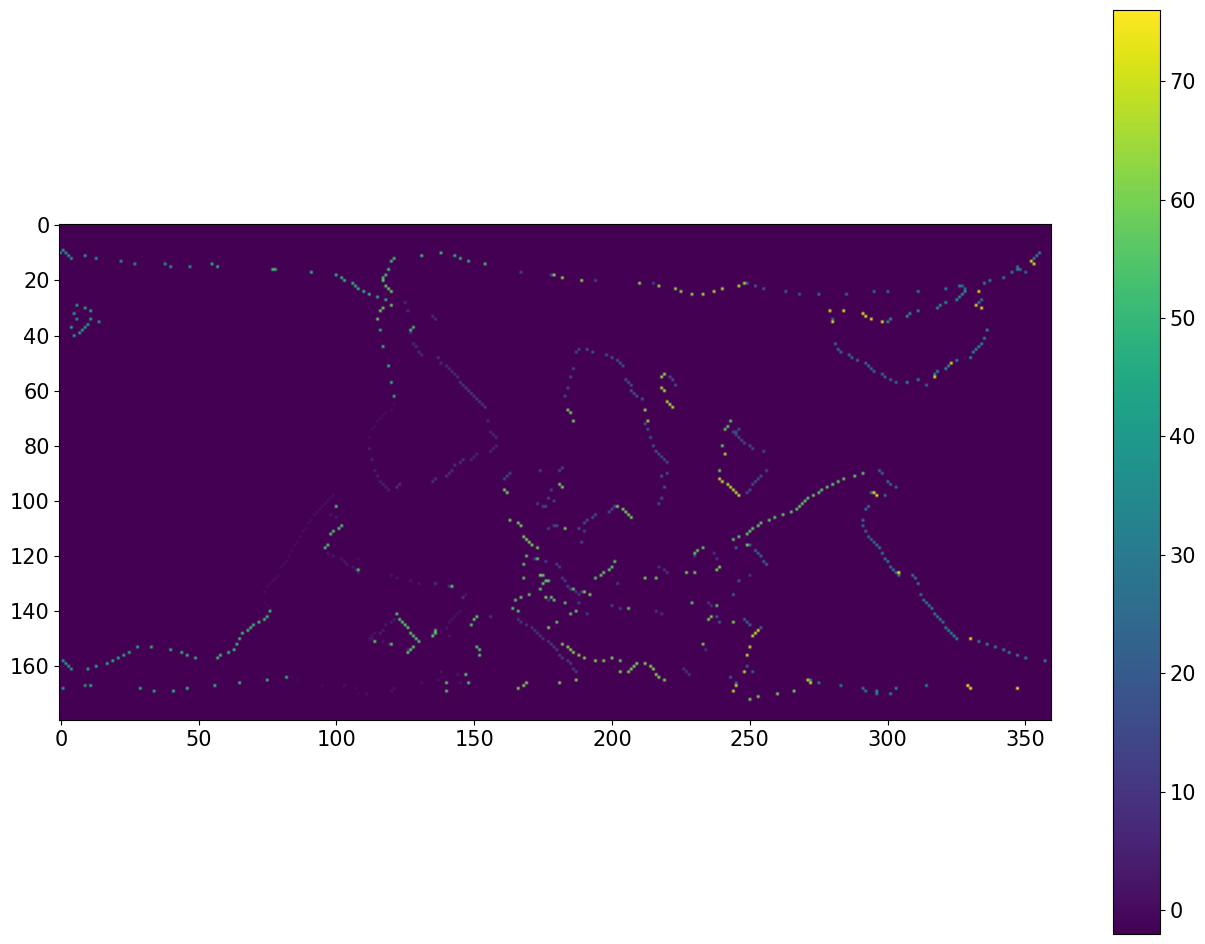

In [130]:
plt.figure(figsize=(16,12))
plt.imshow(arrival_id)
plt.colorbar()

In [113]:
rivers_merged_final

{0: [array([164,  84]),
  array([166,  65]),
  array([137,  74]),
  array([138,  75]),
  array([139,  76]),
  array([165,  86]),
  array([167,  95]),
  array([168, 107]),
  array([170, 108])],
 1: [array([129,  77]),
  array([133,  74]),
  array([131,  75]),
  array([130,  76]),
  array([128,  78]),
  array([127,  79]),
  array([124,  80]),
  array([123,  81]),
  array([122,  82]),
  array([120,  83]),
  array([118,  84]),
  array([116,  85]),
  array([115,  86]),
  array([113,  87]),
  array([111,  88]),
  array([110,  89]),
  array([108,  90]),
  array([107,  91]),
  array([105,  92]),
  array([104,  93]),
  array([103,  94]),
  array([102,  95]),
  array([101,  96]),
  array([100,  97]),
  array([99, 98]),
  array([98, 99]),
  array([121, 108]),
  array([ 77, 112]),
  array([ 74, 113]),
  array([ 73, 114]),
  array([ 71, 115]),
  array([ 70, 116]),
  array([ 69, 117]),
  array([ 68, 118]),
  array([ 67, 120]),
  array([ 65, 121]),
  (100, 100),
  (101, 99),
  (102, 99),
  (103, 98),

In [101]:
not_assigned

[]

In [79]:
basin_thres = 50

First calc: just trace each point to the sea

In [42]:
rnf_map, rivers, rivers_dir = track_rivers(flowdir)

Found 2741 rivers!


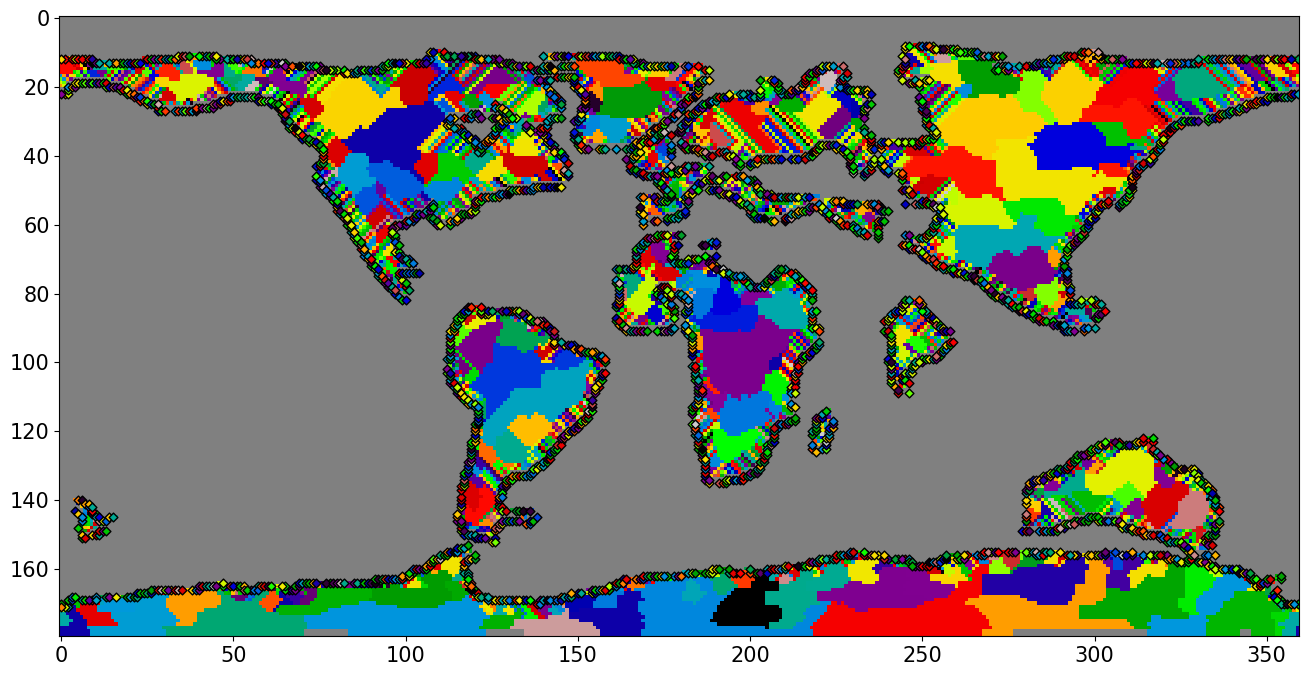

In [13]:
fig = plot_basins(rnf_map, rivers)

Group basins, keeping only the larger ones

In [94]:
basin_thres = 50; riv_thres = 30

In [95]:
big_rivers, big_rivers_dir, big_basins = get_largest_basins(rnf_map, rivers, rivers_dir, lat = oroslope.latitude, basin_thres = basin_thres)

Selecting 39 largest basins!


Repeat the calc, keeping the largest basins and merging points to rivers nearby

In [96]:
rnf_map_merged, rivers_merged, rivers_v2, rivers_v2_dir = track_rivers_and_merge(big_rivers, big_rivers_dir, flowdir = flowdir, riv_thres = riv_thres, dir_thres = 1, use_expanded = True, weight_for_lat = False)

Small river, checking nearby
133.96268137059664 5
No small river nearby, adding one
Small river, checking nearby
Small river, checking nearby
Small river, checking nearby
1.0 39
Found small river nearby!
Small river, checking nearby
1.0 39
Found small river nearby!
Small river, checking nearby
1.0 39
Found small river nearby!
Small river, checking nearby
1.0 39
Found small river nearby!
Small river, checking nearby
162.01234520862909 9
No small river nearby, adding one
Small river, checking nearby
Small river, checking nearby
107.56393447619885 3
No small river nearby, adding one
Small river, checking nearby
1.0 41
Found small river nearby!
Small river, checking nearby
1.4142135623730951 41
Found small river nearby!
Small river, checking nearby
1.0 41
Found small river nearby!
Small river, checking nearby
112.44998888394787 2
No small river nearby, adding one
Small river, checking nearby
Small river, checking nearby
Small river, checking nearby
Small river, checking nearby
Found 43 riv

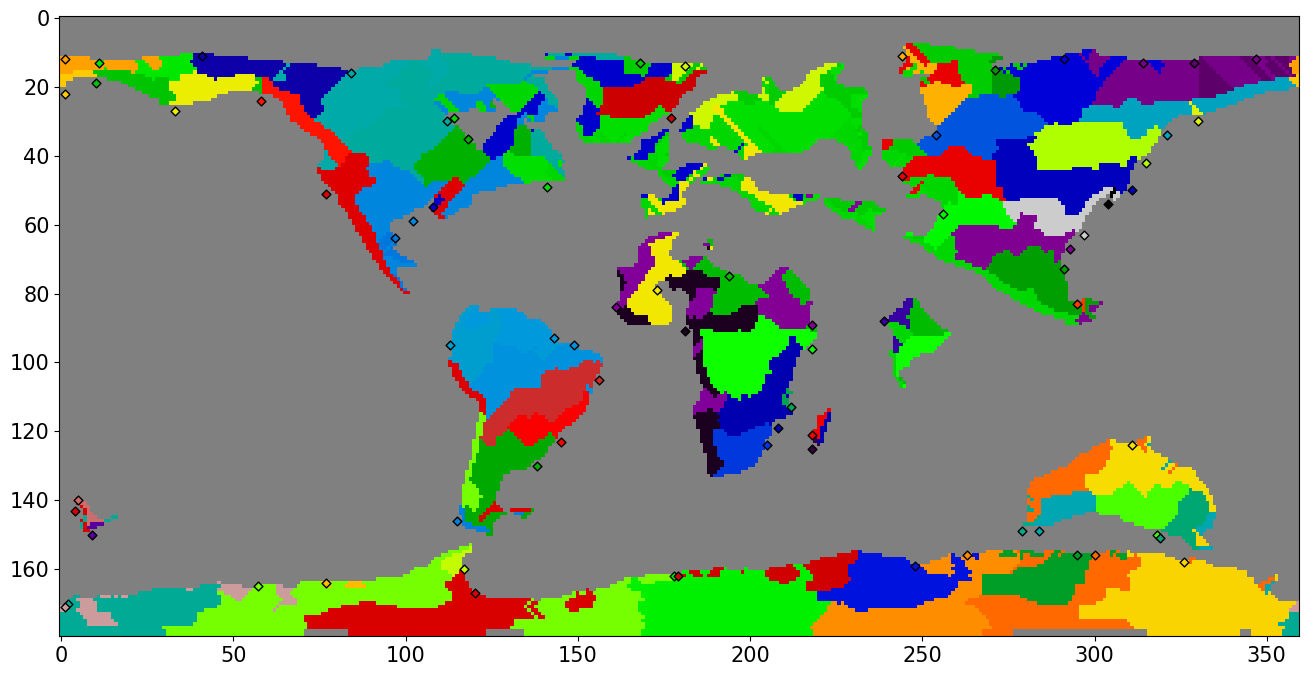

In [34]:
fig = plot_basins(rnf_map_merged, rivers_v2)

In [40]:
basins = calc_basins_dim(rnf_map_merged)

In [97]:
big_rivers_2, big_rivers_dir_2, ok_indx = get_largest_basins(rnf_map_merged, rivers_v2, rivers_v2_dir, lat = oroslope.latitude, basin_thres = basin_thres)

okriv_merged = {ind: rivers_merged[ind] for ind in ok_indx}

for ind in range(len(rivers_merged)):
    if ind not in list(ok_indx):
        print(f'{ind}: small basin, deassigning..')
        rnf_map_merged[rnf_map_merged == ind] = -1


rnf_map_filled = rnf_map_merged.copy()
nla, nlo = rnf_map_merged.shape

missing = True
i_count = 0
while missing and i_count < 20:
    print(f'We are at {i_count} round of assignments')
    i_count += 1
    missing = False
    not_assigned = []
    for i in range(nla):
        for j in range(nlo):
            if rnf_map_filled[i,j] == -1:
                print('To be assigned')
                # Search for neighboring points

                #print(i-1, i+2, j-1, j+2)
                ini_i = i-1
                ini_j = j-1
                if ini_i < 0: ini_i = 0
                if ini_j < 0: ini_j = 0
                cose = rnf_map_filled[ini_i:i+2, ini_j:j+2].flatten()
                print(cose)

                if np.any(cose >= 0):
                    # assign closest non-zero
                    new_ind = cose[np.where(cose >= 0)[0][0]]
                    print(f'Assigning to {new_ind}')
                    rnf_map_filled[i, j] = int(new_ind)
                else:
                    missing = True
                    not_assigned.append((i,j))


Selecting 54 largest basins!
40: small basin, deassigning..
41: small basin, deassigning..
42: small basin, deassigning..
43: small basin, deassigning..
44: small basin, deassigning..
45: small basin, deassigning..
46: small basin, deassigning..
47: small basin, deassigning..
53: small basin, deassigning..
54: small basin, deassigning..
57: small basin, deassigning..
58: small basin, deassigning..
63: small basin, deassigning..
64: small basin, deassigning..
65: small basin, deassigning..
67: small basin, deassigning..
69: small basin, deassigning..
70: small basin, deassigning..
72: small basin, deassigning..
73: small basin, deassigning..
74: small basin, deassigning..
75: small basin, deassigning..
76: small basin, deassigning..
We are at 0 round of assignments
To be assigned
[48. -1. -1. 48. -1. -1.]
Assigning to 48.0
To be assigned
[48. -1. -1. -1. -1. -1.]
Assigning to 48.0
To be assigned
[48. -1. -1. -1. -1. -1.]
Assigning to 48.0
To be assigned
[48. -1. -1. -1. -1. -1.]
Assigni

In [28]:
i = 100
j = 170
cose = rnf_map_merged[i-1:i+2, :][:, j-1:j+2].flatten()

In [33]:
np.where(cose >= 0)[0][0]

np.int64(0)

In [98]:
rnf_map_merged.shape

(180, 360)

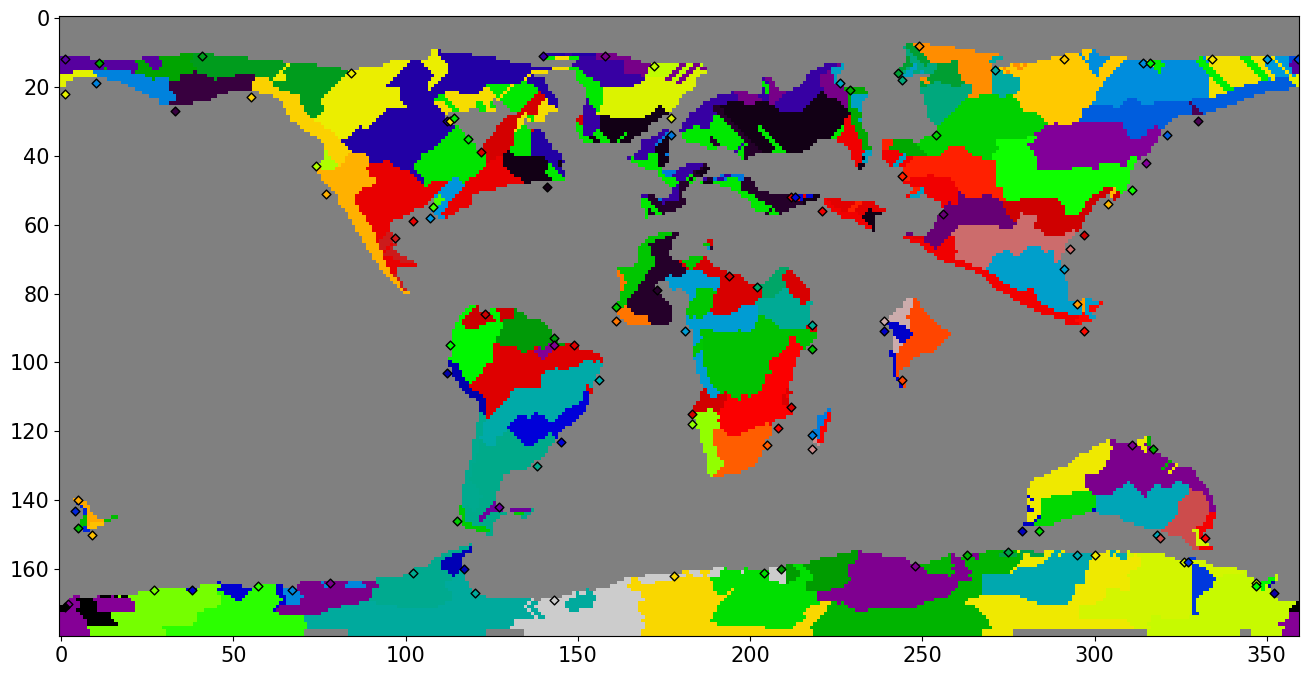

In [19]:
fig = plot_basins(rnf_map_merged, rivers_v2)

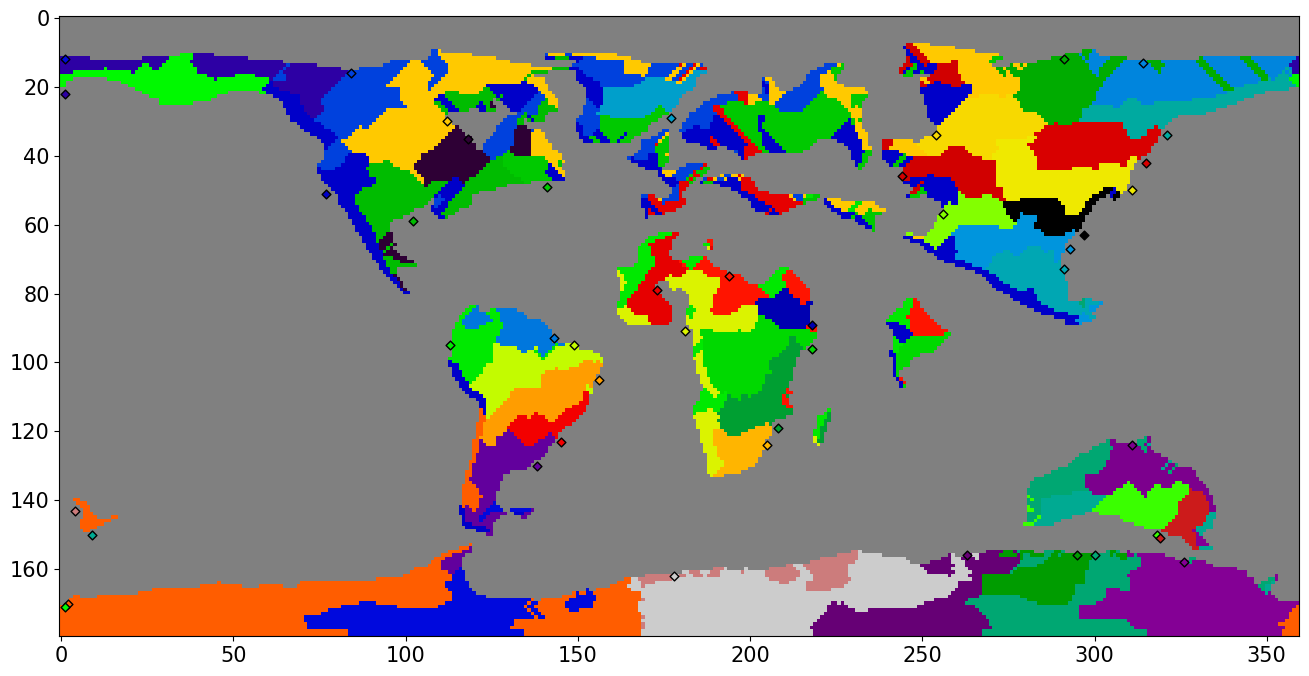

In [70]:
fig = plot_basins(rnf_map_filled, rivers_v2, not_assigned=not_assigned)

In [99]:
not_assigned

[]

Points that do not go anywhere (all at South pole)

In [53]:
lakes = np.where(rnf_map_filled[::-1, :] == -1)
#plt.scatter(lakes[1], lakes[0], s = 20, marker = 'x', color = 'white')

lakes

(array([171, 172, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179]),
 array([  0,   0,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
        290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302,
        303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
        343, 344, 345]))

## Produce file for runoff mapper

In [71]:
rnf_pd = xr.load_dataset(cart + 'runoff_maps.nc')

In [73]:
rnf_pd

<xarray.Dataset> Size: 2MB
Dimensions:            (lon: 512, lat: 256)
Coordinates:
  * lon                (lon) float64 4kB 0.0 0.7031 1.406 ... 357.9 358.6 359.3
  * lat                (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.77 89.46
Data variables:
    drainage_basin_id  (lat, lon) int32 524kB 66 66 66 66 66 ... -2 -2 -2 -2 -2
    arrival_point_id   (lat, lon) int32 524kB -1 -1 -1 -1 -1 ... -2 -2 -2 -2 -2
    calving_point_id   (lat, lon) int32 524kB -1 -1 -1 -1 -1 ... -2 -2 -2 -2 -2
Attributes:
    ece-origin:  Klaus Wyser (SMHI) for EC-Earth

Adding cyclic point



<GeoAxes: >

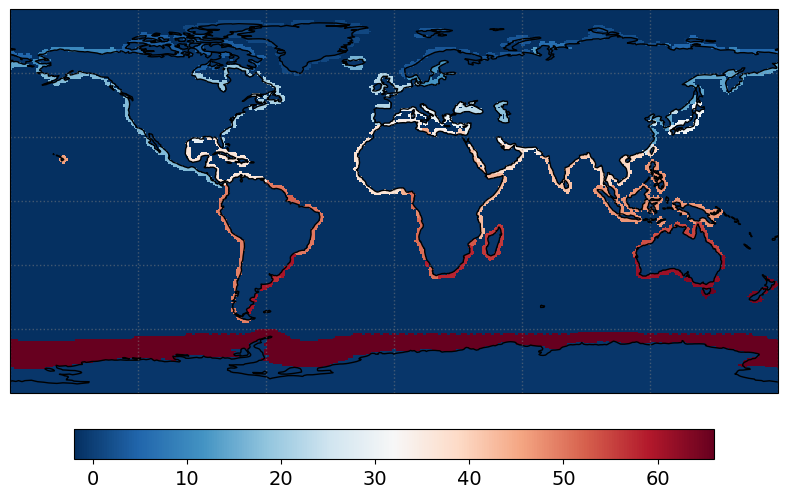

In [72]:
ctl.plot_map_contour(rnf_pd.arrival_point_id, plot_type='pcolormesh')

In [115]:
rnf_pd.arrival_point_id.min()

<xarray.DataArray 'arrival_point_id' ()> Size: 4B
array(-2, dtype=int32)

In [74]:
for co in rivers_merged:
    print(co, len(rivers_merged[co]))

0 41
1 88
2 35
3 24
4 14
5 36
6 7
7 4
8 20
9 10
10 35
11 10
12 10
13 26
14 9
15 16
16 12
17 24
18 10
19 12
20 2
21 5
22 8
23 4
24 7
25 10
26 24
27 2
28 6
29 5
30 9
31 7
32 6
33 15
34 13
35 15
36 4
37 6
38 6
39 26
40 12
41 9
42 6
43 3
44 2
45 8
46 3
47 10
48 9
49 12
50 1
51 1


In [75]:
np.stack(rivers_merged[0])[:, 0]

array([164, 166, 137, 138, 139, 165, 167, 168, 125, 141, 143, 144, 145,
       146, 148, 149, 150, 151, 147, 169, 153, 154, 140, 128, 127, 129,
       135, 136, 152, 132, 155, 156, 133, 157, 134, 158, 162, 159, 160,
       161, 163])

In [76]:
np.any(rivers_merged[0] == np.array([166,  65]))

np.True_

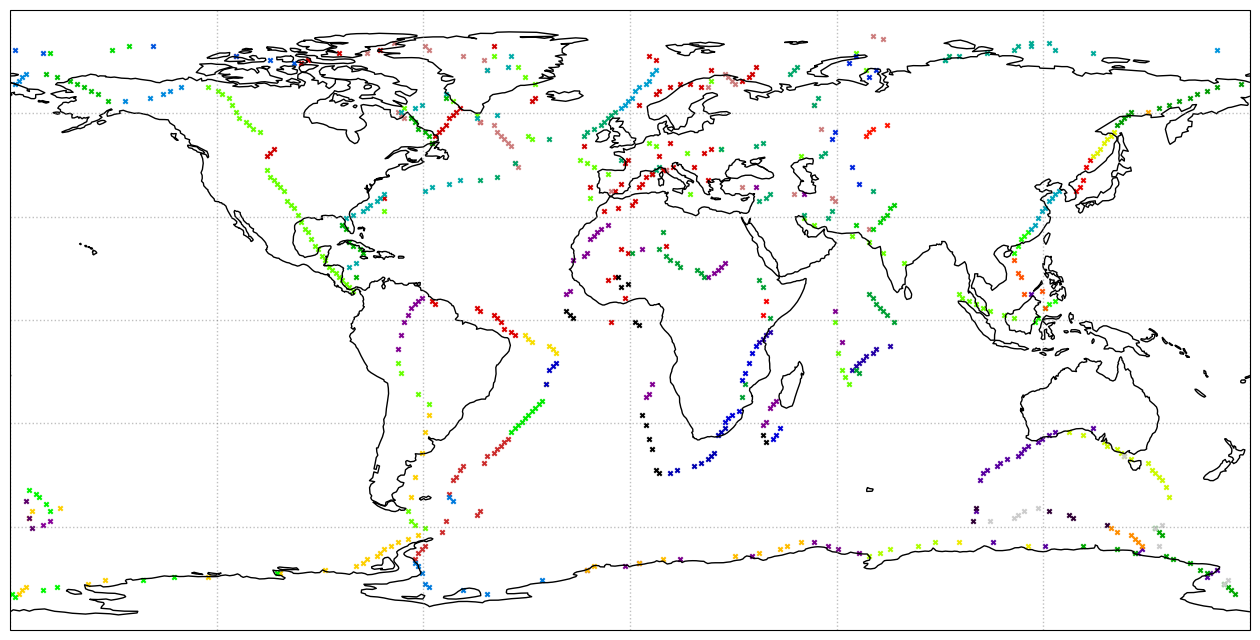

In [77]:
from cartopy import crs as ccrs

fig, ax = ctl.get_cartopy_fig_ax()

cmap = plt.get_cmap('nipy_spectral')
indices = np.linspace(0, 1, len(rivers_merged))
colors = [cmap(i) for i in indices]
np.random.shuffle(colors)

for ii, col in zip(rivers_merged, colors):
    yi = np.stack(rivers_merged[ii])[:, 0]
    xi = np.stack(rivers_merged[ii])[:, 1]
    plt.scatter(oroslope.longitude[xi], oroslope.latitude[yi], transform = ccrs.PlateCarree(), s = 10, marker = 'x', color = col)